# Examples of using the various functions in `Utils`

In [1]:
import os

import polartoolkit as ptk

In [2]:
# set default to southern hemisphere for this notebook
os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

## Grid processes

### Fit a trend to a grid and optionally remove it

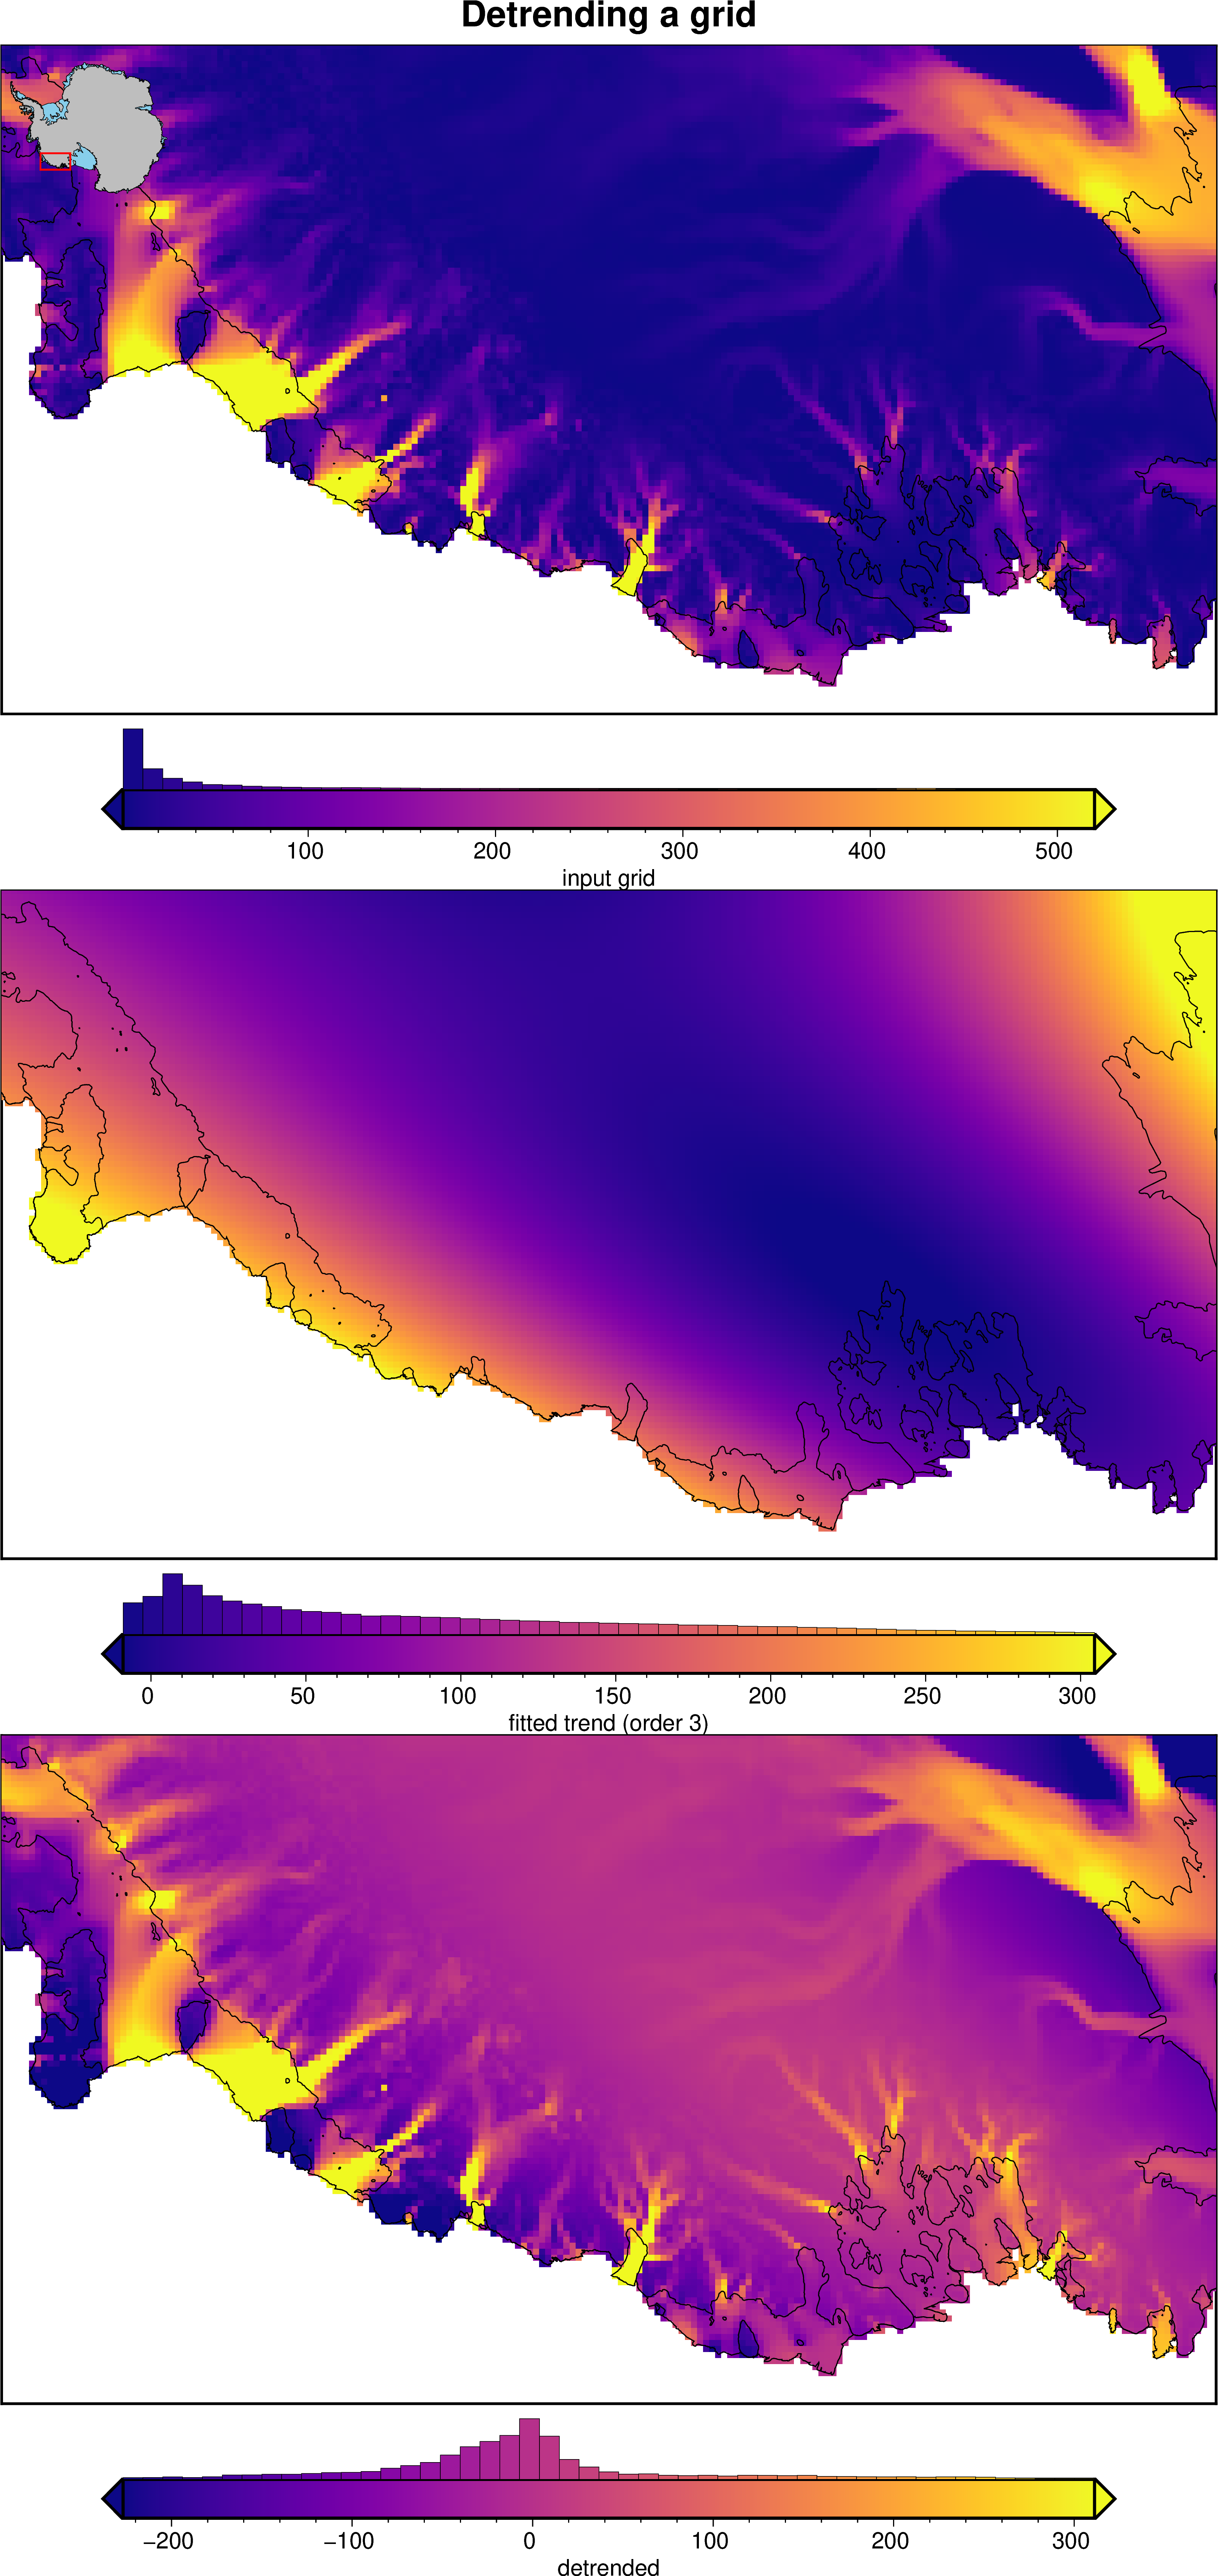

In [4]:
# download
ice_velocity = ptk.fetch.ice_vel(
    region=ptk.regions.marie_byrd_land,
    spacing=5e3,
)

# extract and detrend
fit, detrend = ptk.grid_trend(
    ice_velocity,
    deg=3,
    plot=True,
)

### compare two different grids

In [5]:
# define a region of interest
region = ptk.regions.pine_island_glacier

# load the 2 grids to compare, at 1km resolution
bedmachine = ptk.fetch.bedmachine(
    layer="bed",
    spacing=1e3,
    region=region,
)
bedmap = ptk.fetch.bedmap2(
    layer="bed",
    spacing=1e3,
    region=region,
)

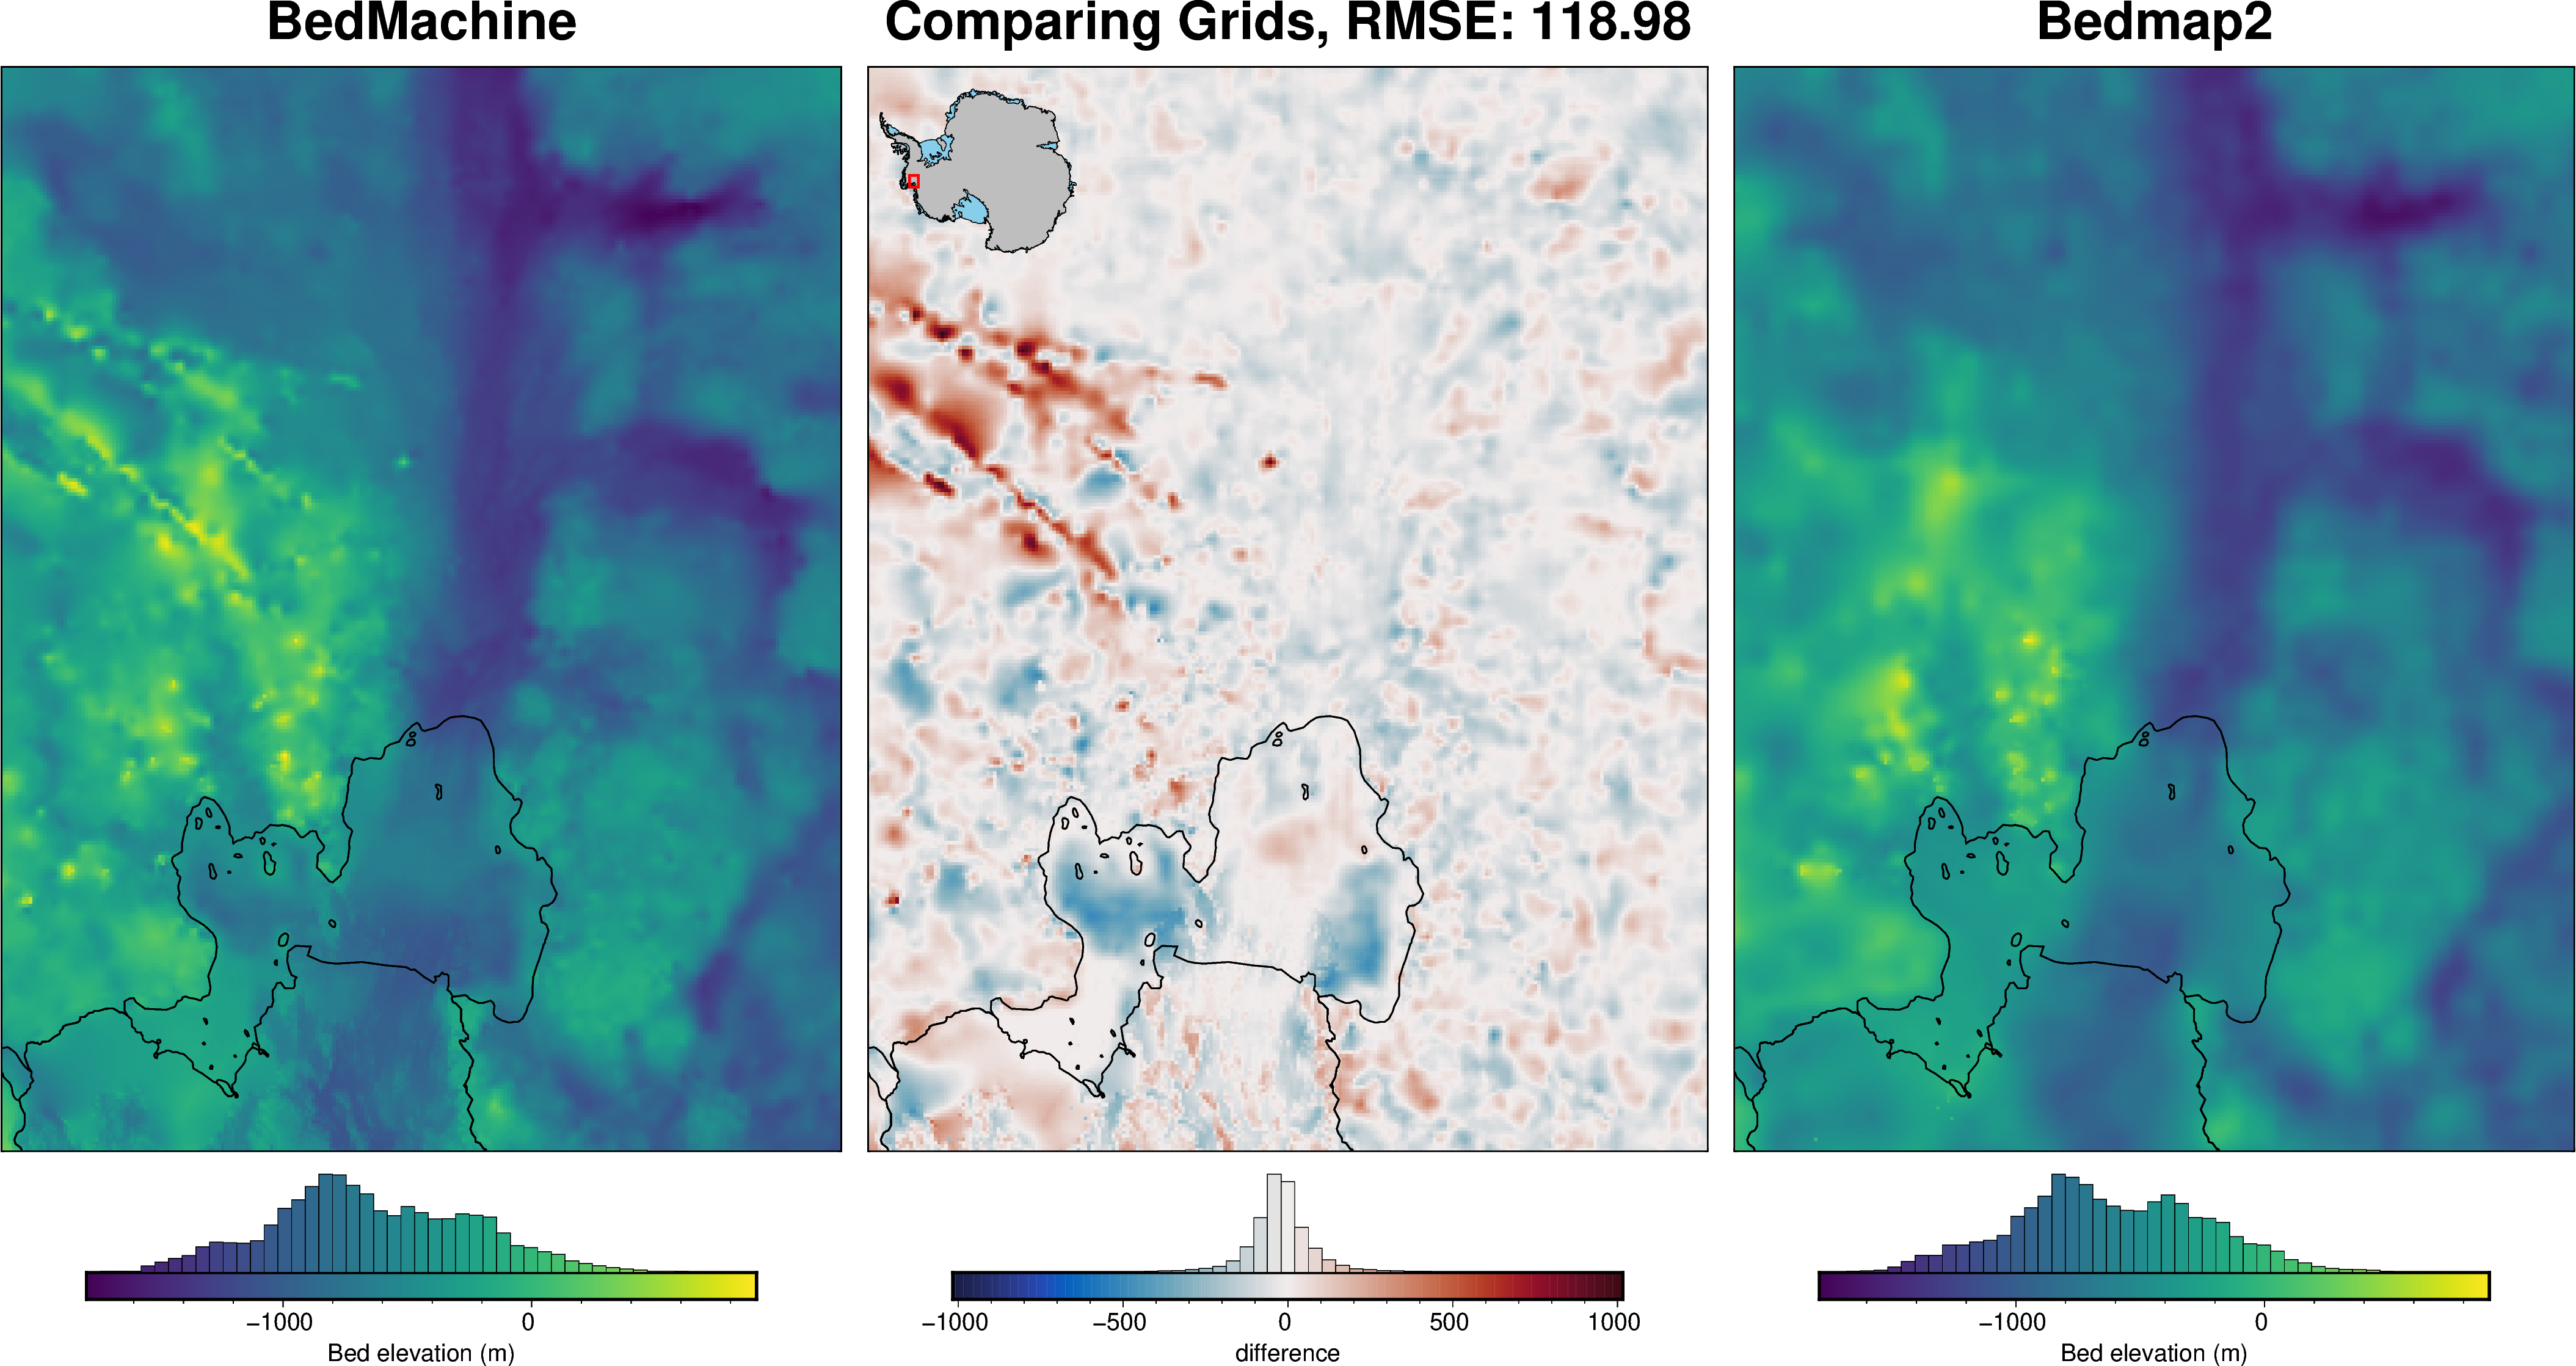

In [6]:
# run the difference function and plot the results
dif, grid1, grid2 = ptk.grid_compare(
    bedmachine,
    bedmap,
    coast=True,
    grid1_name="BedMachine ",
    grid2_name="Bedmap2",
    cbar_label="Bed elevation (m)",
    hist=True,
)

Lets say we're only interested in the region under the ice shelf (the closed black polygon). Higher or lower values outside of the ice shelf are skewing the color ramp. We can use a regional mask to set the colorscale's max and min values based on a shapefile. We'll define a shapefile for the land, and re-run the above code with the kwarg `shp_mask`.

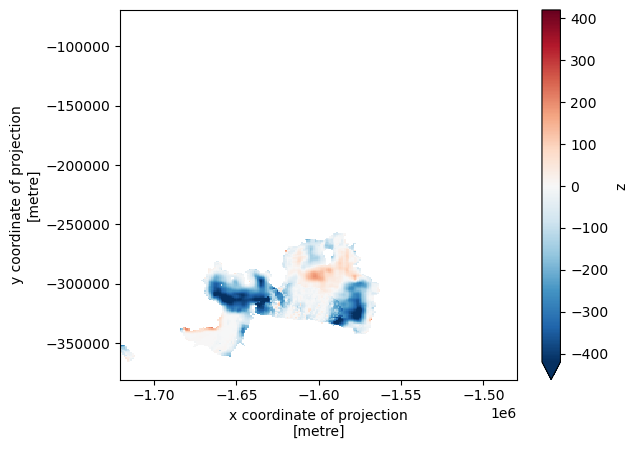

In [7]:
# load the grounding and coast line database
import geopandas as gpd

shp = gpd.read_file(ptk.fetch.groundingline(version="depoorter-2013"))

# subset only the ice shelf region for the mask. See the Fetch Walkthrough for the
# groundingline ID classifications
shp_mask = shp[shp.Id_text == "Ice shelf"]

# view the mask area:
ptk.mask_from_shp(
    shp_mask,
    grid=dif,
    masked=True,
    invert=False,
).plot(robust=True)

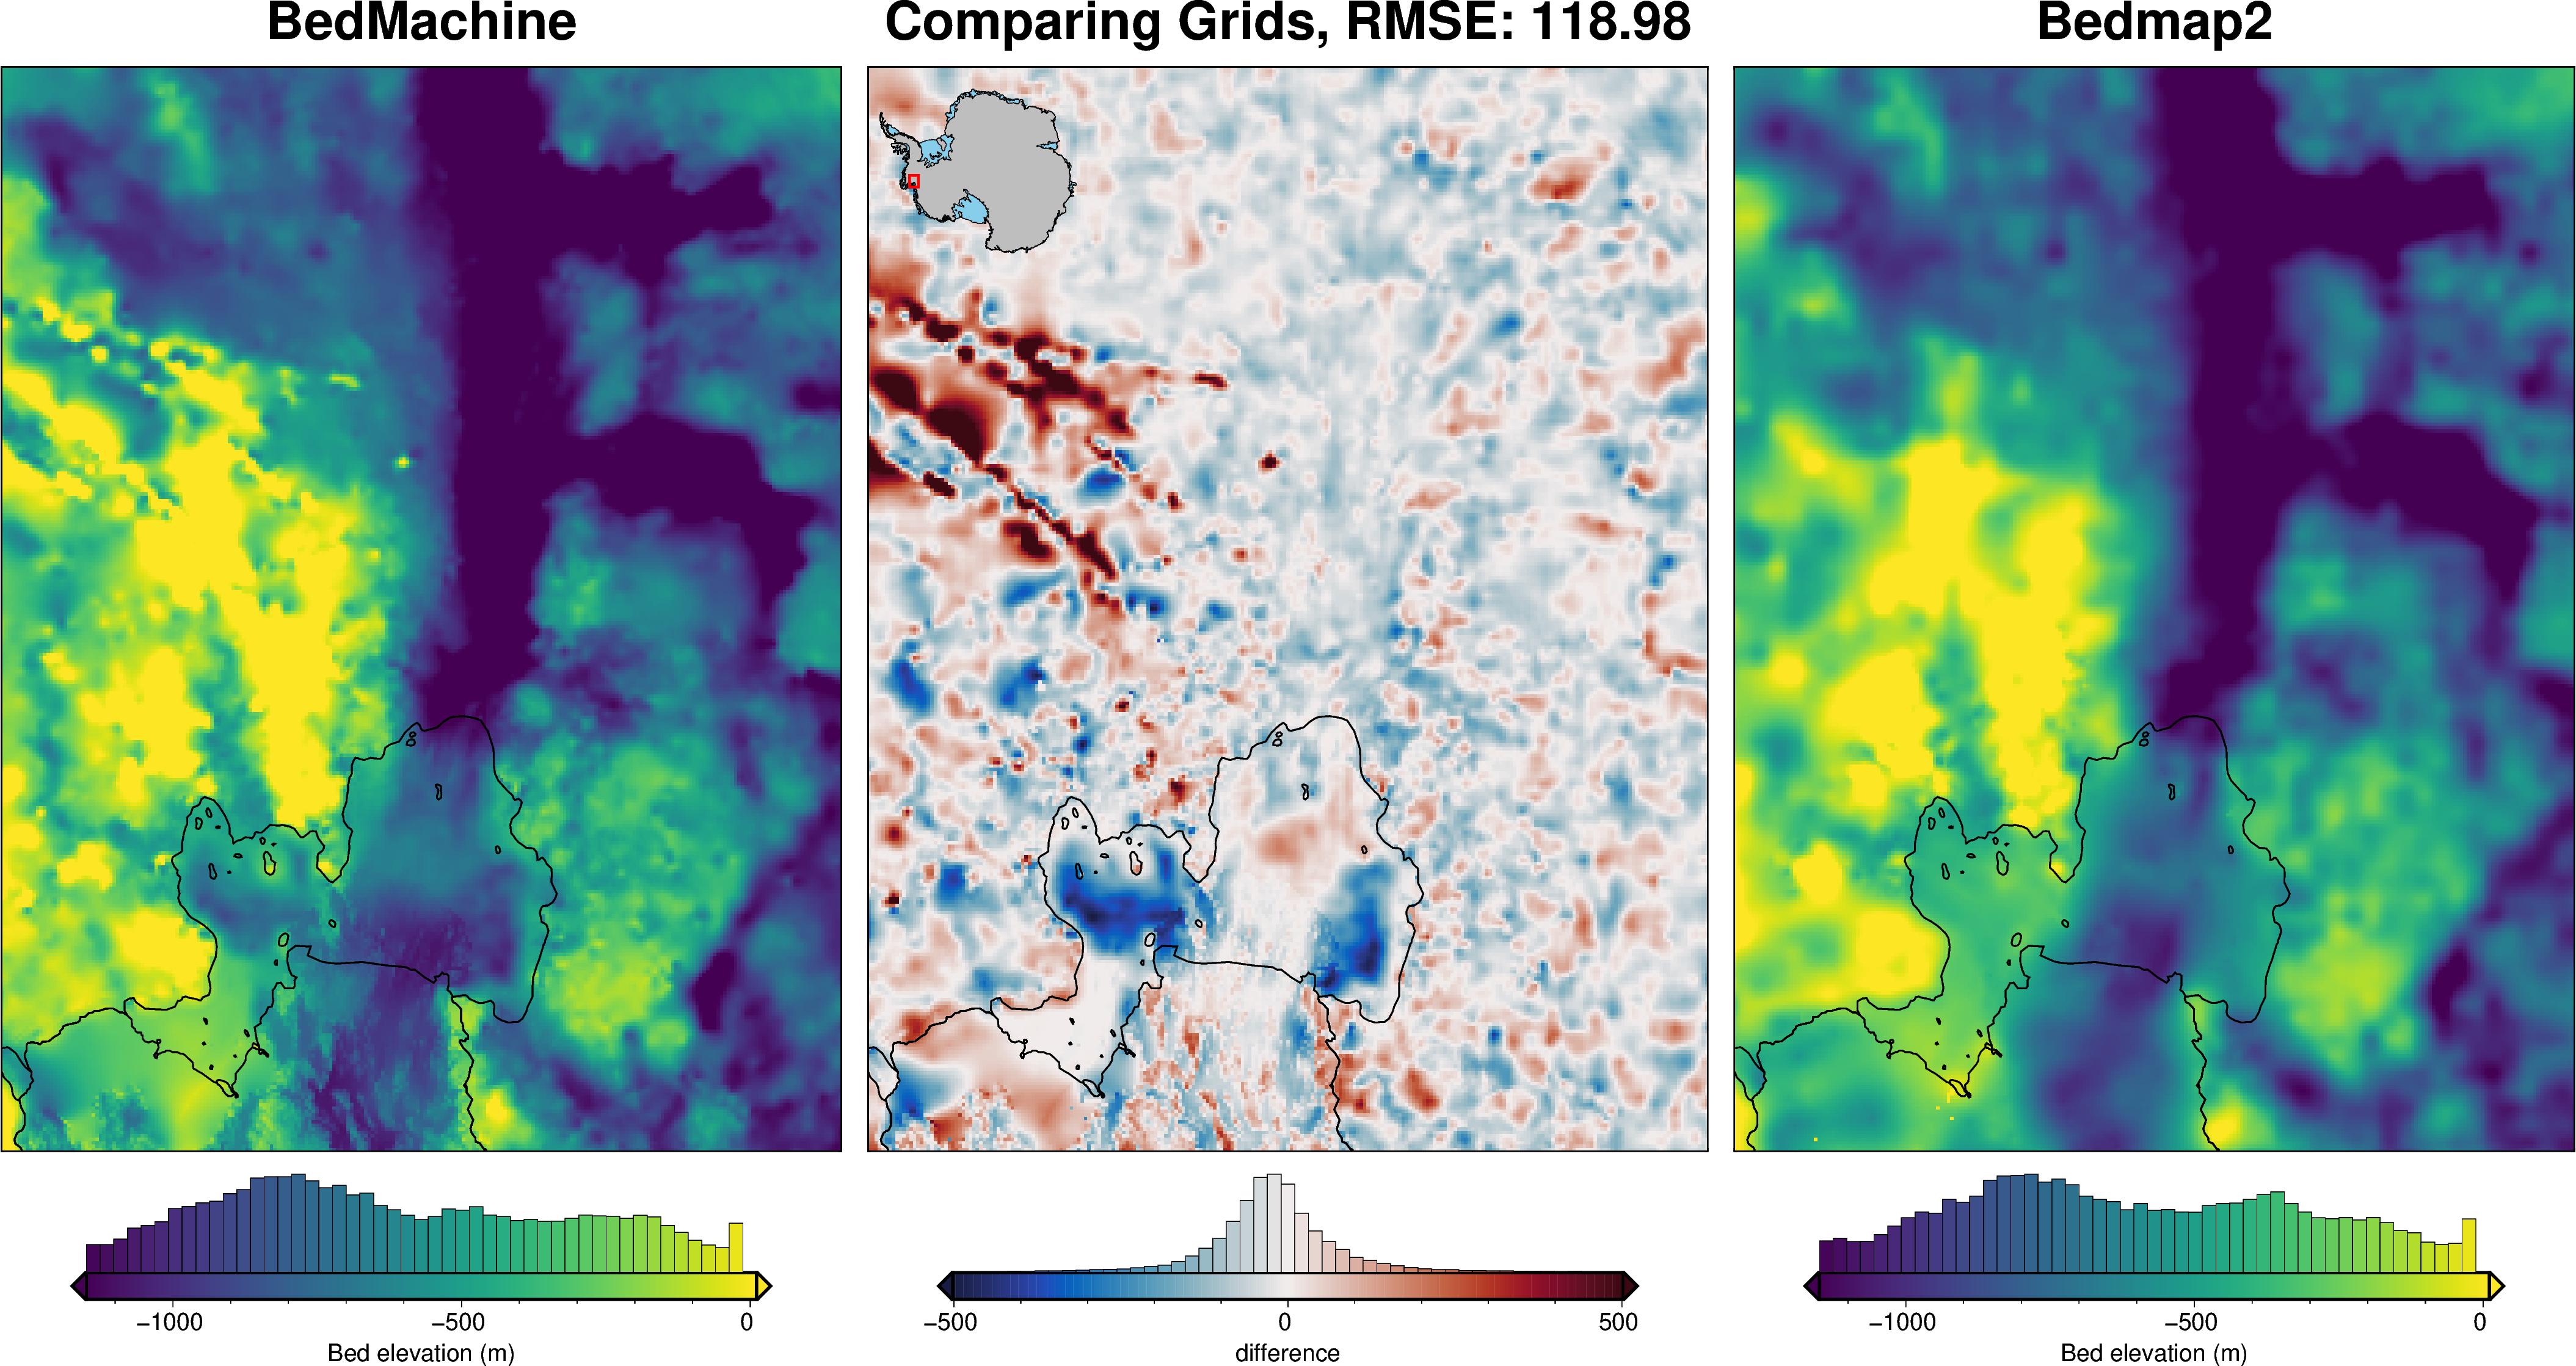

In [8]:
# re-run the difference function.
# note how the color scale are now set to just the sub-ice-shelf regions.
dif, grid1, grid2 = ptk.grid_compare(
    bedmachine,
    bedmap,
    coast=True,
    grid1_name="BedMachine ",
    grid2_name="Bedmap2",
    cbar_label="Bed elevation (m)",
    hist=True,
    shp_mask=shp_mask,
)

### Interactively mask a grid

In [9]:
polygon = ptk.draw_region(
    points=ptk.region_to_df(region),  # plot corners of region
)

Label(value='')

Map(center=[np.float64(-75.1282216924775), np.float64(-97.58308196293555)], controls=(ZoomControl(options=['po…

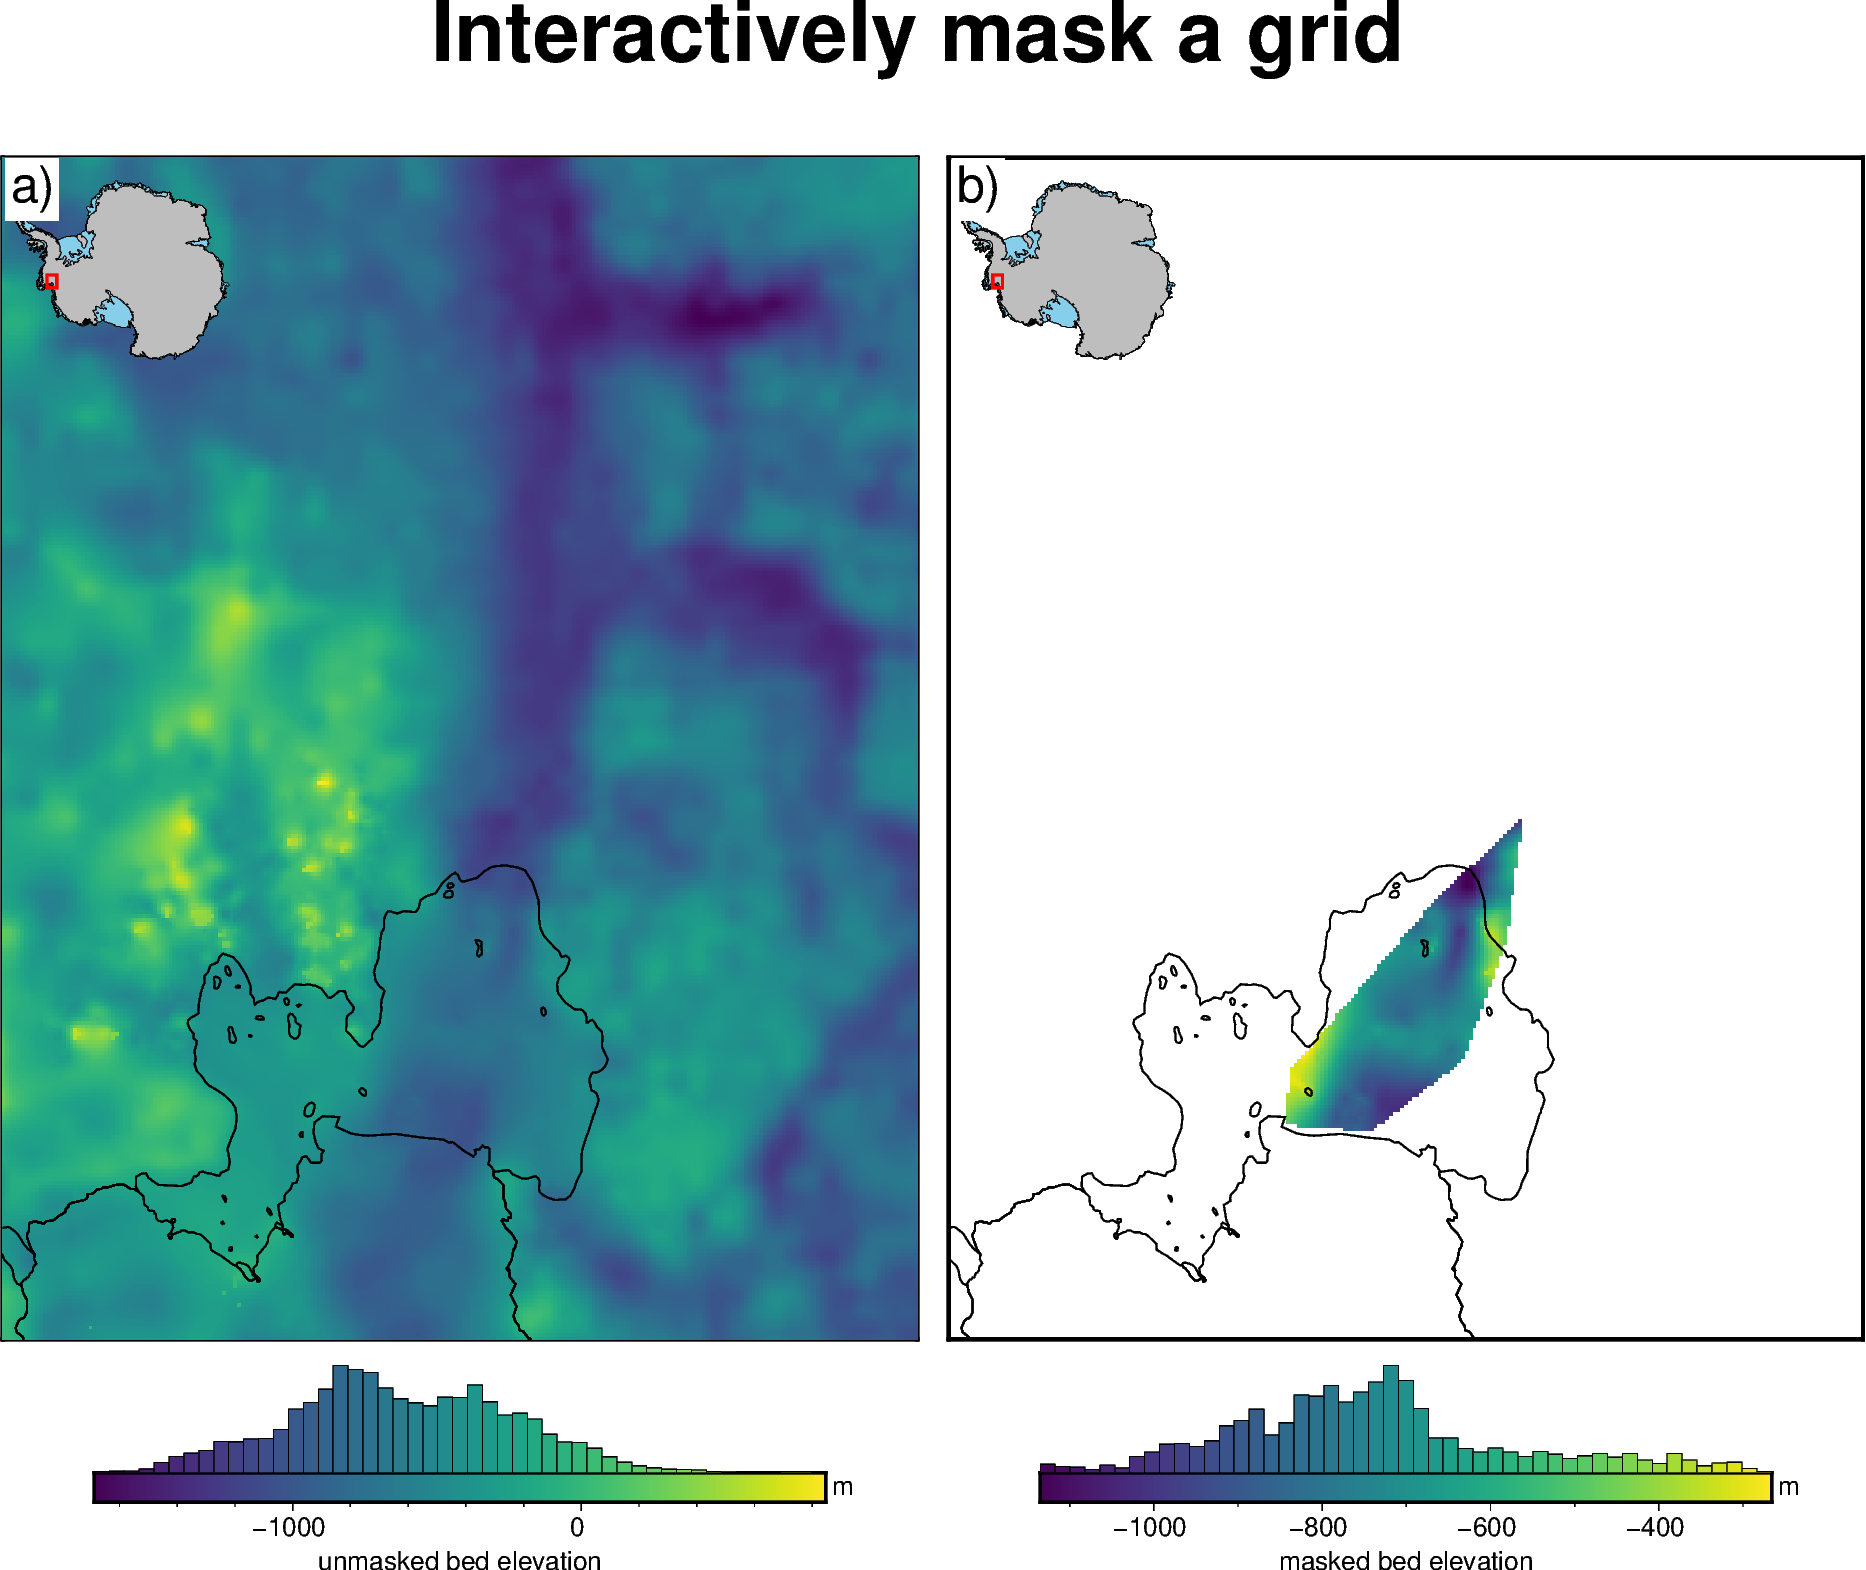

In [10]:
masked = ptk.mask_from_polygon(
    polygon,
    grid=bedmap,
)

# show results in a plot
fig = ptk.subplots(
    [bedmap, masked],
    region=ptk.regions.pine_island_glacier,
    coast=True,
    inset=True,
    fig_title="Interactively mask a grid",
    cbar_labels=["unmasked bed elevation", "masked bed elevation"],
    cbar_unit="m",
    hist=True,
)

fig.show(dpi=200)